# 0) Setup

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Utils
import sys
from watermark import watermark
from loguru import logger
from skimpy import skim

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Seed for reproducibility
np.random.seed(42)

# Config
logger_format = (
    "<green>{time:MMM-D HH:mm:ss.SSS}</green> | "
    "<level>{level: <8}</level> | "
    "<level>{message}</level>"
)
logger.configure(extra={"ip": "", "user": ""})
logger.remove()
logger.add(sys.stderr, format=logger_format)

#sns.set_style("darkgrid")  # adds seaborn style to charts, eg. grid
#plt.style.use("dark_background")  # inverts colors to dark theme
pass

In [2]:
# Watermark
wmrk_dict = {
    'author':'Gustavo Morales',
    'current_date':True,
    'updated':True,
    'python':True,
    'packages':'pandas,numpy',
}

print(watermark(**wmrk_dict))

Author: Gustavo Morales

Last updated: 2024-09-21

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.27.0

pandas: 2.2.2
numpy : 1.26.4



# 1) Data load

In [3]:
input_file_path = "../data/raw/milling_equipment_data.csv"
df = pd.read_csv(input_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   equipment_id      7200 non-null   object 
 1   timestamp         7200 non-null   object 
 2   temperature       7200 non-null   float64
 3   vibration_x       6480 non-null   float64
 4   vibration_y       7200 non-null   float64
 5   vibration_z       7200 non-null   float64
 6   pressure          7200 non-null   float64
 7   rotational_speed  6480 non-null   float64
 8   maintenance       7200 non-null   int64  
 9   failure           7200 non-null   int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 562.6+ KB


In [4]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7200   │ │ float64     │ 6     │                                                          │
│ │ Number of columns │ 10     │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %  ┃ mean     ┃ sd       ┃ p0    ┃ p25    ┃ p50    ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ temperature        │    0 │     0 │    79.96 │    9.536 │    60 │  73.29 │  80.03 │ 86.73 │   100 │ ▃▅▇▇▅▃ │  │
│ │ vibration_x        │  720 │    10 │  0.04985 │  0.01965 │  0.01 │  0.036 │  0.049 │ 0.063 │  0.14 │  ▃▇▆▂  │  │
│ │ vibration_y        │    0 │     0 │  0.05019 │  0.01975 │  0.01 │  0.036 │   0.05 │ 0.064 │ 0.125 │ ▃▇▇▃▁  │  │
│ │ vibration_z        │    0 │     0 │  0.05018 │  0.01947 │  0.01 │  0.037 │   0.05 │ 0.063 │ 0.129 │  ▃▇▇▃  │  │
│ │ pressure           │    0 │     0 │    5.006 │   0.4804 │     4 │   4.67 │      5 │  5.34 │     6 │ ▃▅▇▇▅▃ │  │
│ │ rotational_speed   │  720 │    10 │     1500 │    47.57 │  1400 │   1466 │   1500 │  1533 │  1600 │ ▃▅▇▇▅▃ │  │
│ │ maintenance        │    0 │     0 │  0.04778 │   0.2133 │     0 │      0 │      0 │     0 │     1 │   ▇    │  │
│ │ failure            │    0 │     0 │  0.03153 │   0.1748 │     0 │      0 │      0 │     0 │     1 │   ▇    │  │
│ └────────────────────┴──────┴───────┴──────────┴──────────┴───────┴────────┴────────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA     ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ equipment_id               │      0 │          0 │                            1 │                     7200 │  │
│ │ timestamp                  │      0 │          0 │                            2 │                    14400 │  │
│ └────────────────────────────┴────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

# 2) Data Prep

## 2a) Handle missing values

In [5]:
# Check for missing values
print(df.isnull().sum())

equipment_id          0
timestamp             0
temperature           0
vibration_x         720
vibration_y           0
vibration_z           0
pressure              0
rotational_speed    720
maintenance           0
failure               0
dtype: int64


In [6]:
# Assume 'maintenance' and 'failure' have no missing values
# Impute numerical features with median
num_features = ['temperature', 'vibration_x', 'vibration_y', 'vibration_z', 'pressure', 'rotational_speed']
imputer_num = SimpleImputer(strategy='median')
df[num_features] = imputer_num.fit_transform(df[num_features])

In [7]:
# Here, 'maintenance' is already binary
# and 'equipment_id' is a categorical variable and may require encoding
# Check unique values
print(df['equipment_id'].unique())

['E1' 'E10' 'E8' 'E6' 'E4' 'E9' 'E7' 'E3' 'E2' 'E5']


In [8]:
# Since 'equipment_id' is an identifier, it might not be useful as a feature unless multiple equipment behave differently
# For simplicity, we can drop it or encode it
# Let's encode it using Label Encoding
le = LabelEncoder()
df['equipment_id'] = le.fit_transform(df['equipment_id'])

In [9]:
print(df['equipment_id'].unique())

[0 1 8 6 4 9 7 3 2 5]


In [10]:
# Verify no missing values remain
print(df.isnull().sum())

equipment_id        0
timestamp           0
temperature         0
vibration_x         0
vibration_y         0
vibration_z         0
pressure            0
rotational_speed    0
maintenance         0
failure             0
dtype: int64


## 2b) Feature Engineering

In [11]:
# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Drop 'timestamp' as it's now represented by new features
df.drop('timestamp', axis=1, inplace=True)

# Feature Aggregation (optional)
# For simplicity, proceed without aggregation

In [12]:
df.head()

,equipment_id,temperature,vibration_x,vibration_y,vibration_z,pressure,rotational_speed,maintenance,failure,hour,day,month,dayofweek
0,0,85.95,0.049,0.047,0.051,4.25,1461.0,0,0,13,23,1,0
1,1,72.49,0.060,0.045,0.066,4.78,1498.0,0,0,9,10,1,1
2,8,67.24,0.059,0.071,0.038,4.21,1477.0,0,0,23,27,1,4
3,6,92.13,0.062,0.055,0.041,5.20,1580.0,0,0,8,9,1,0
4,4,89.27,0.036,0.040,0.037,4.83,1571.0,0,0,17,10,1,1


## 2c) Encode Categorical Variables

In [13]:
# 'equipment_id' has been label encoded
# 'maintenance' and 'failure' are already binary

# Verify 'equipment_id' is numeric
df['equipment_id'].dtype

dtype('int64')

## 2d) Feature Scaling

In [14]:
# Features to scale
features_to_scale = [
    'temperature',
    'vibration_x', 'vibration_y', 'vibration_z', 
    'pressure', 'rotational_speed',
    'hour', 'day', 'month', 'dayofweek'
    ]

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [15]:
# Display scaled features
df[features_to_scale].head()

,temperature,vibration_x,vibration_y,vibration_z,pressure,rotational_speed,hour,day,month,dayofweek
0,0.628484,-0.041257,-0.161294,0.041868,-1.574379,-0.864472,0.216695,0.866507,0.0,-1.441153
1,-0.783112,0.548764,-0.262551,0.812320,-0.471004,-0.044498,-0.361158,-0.635438,0.0,-0.960769
2,-1.333697,0.495126,1.053790,-0.625857,-1.657652,-0.509889,1.661325,1.328644,0.0,0.480384
3,1.276601,0.656040,0.243734,-0.471766,0.403368,1.772741,-0.505621,-0.750973,0.0,-1.441153
4,0.976663,-0.738554,-0.515693,-0.677220,-0.366912,1.573288,0.794547,-0.635438,0.0,-0.960769


# 3) EDA

## 3a) Distribution of Failure

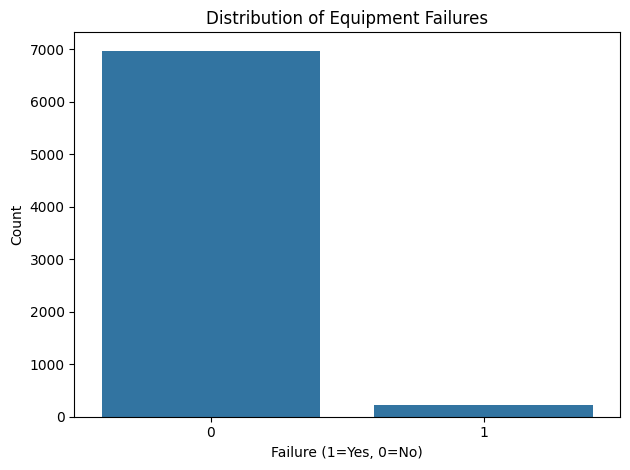

In [16]:
# Distribution of failure
sns.countplot(x='failure', data=df)
plt.title('Distribution of Equipment Failures')
plt.xlabel('Failure (1=Yes, 0=No)')
plt.ylabel('Count')
plt.tight_layout()

<div class="alert alert-info">
This visualization helps in understanding the class imbalance.
</div>

## 3b) Correlation Heatmap

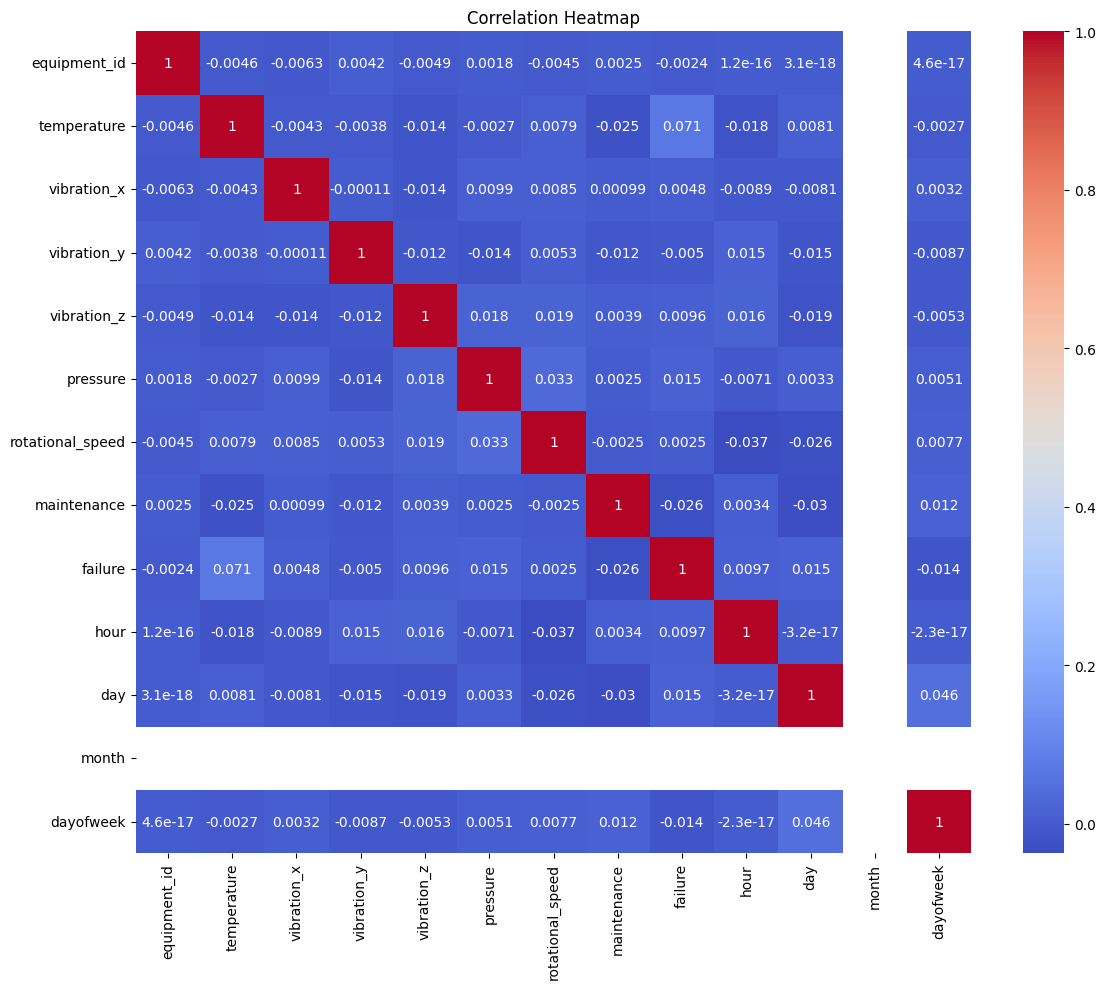

In [17]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()

<div class="alert alert-info">
By design there is no correlation because everything is random, but this visualization can gives us more insight about potentially correlated columns (that we can drop).
</div>

## 3c) Analyzing Key Features Against Failure

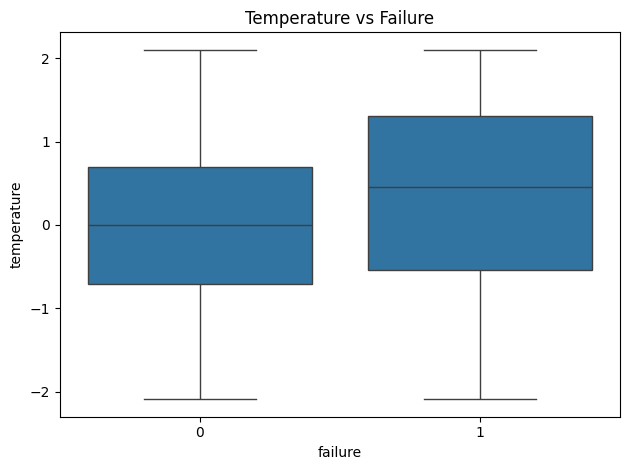

In [18]:
# Temperature vs Failure
sns.boxplot(x='failure', y='temperature', data=df)
plt.title('Temperature vs Failure')
plt.tight_layout()

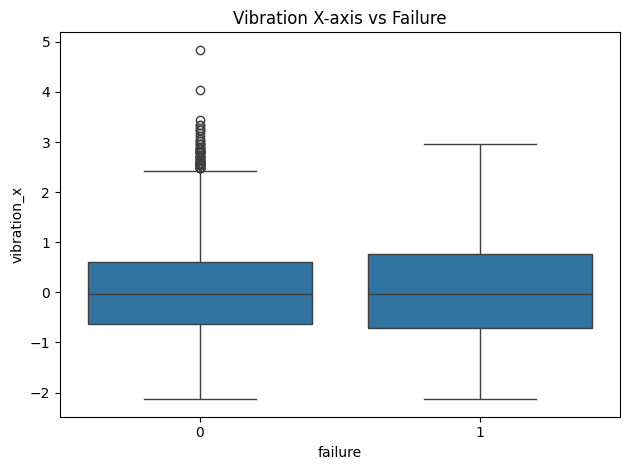

In [19]:
# Vibration_X vs Failure
sns.boxplot(x='failure', y='vibration_x', data=df)
plt.title('Vibration X-axis vs Failure')
plt.tight_layout()

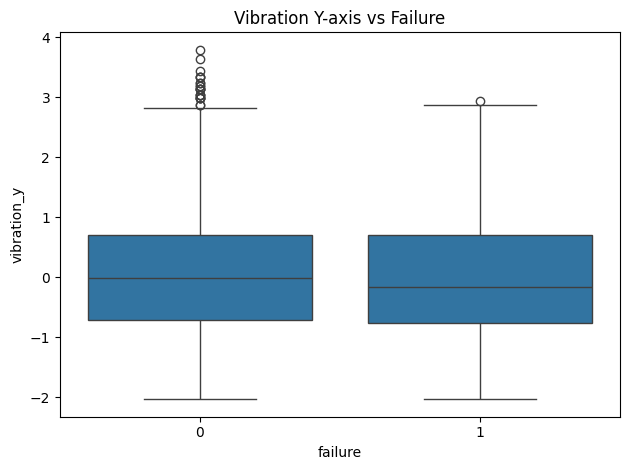

In [20]:
# Vibration_Y vs Failure
sns.boxplot(x='failure', y='vibration_y', data=df)
plt.title('Vibration Y-axis vs Failure')
plt.tight_layout()

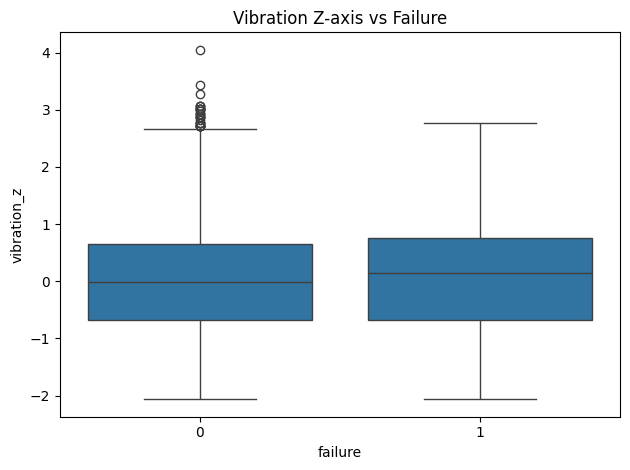

In [21]:
# Vibration_Z vs Failure
sns.boxplot(x='failure', y='vibration_z', data=df)
plt.title('Vibration Z-axis vs Failure')
plt.tight_layout()

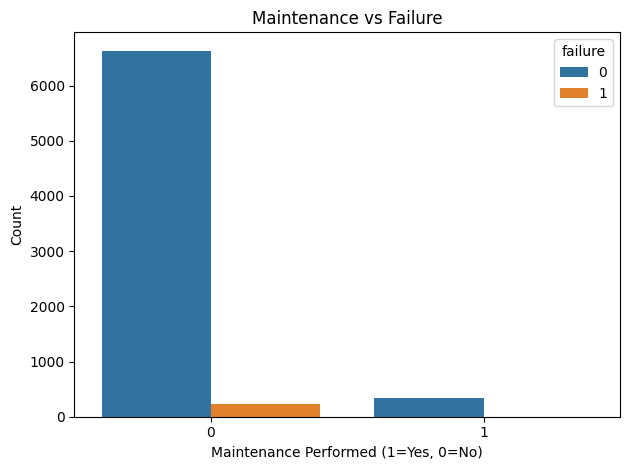

In [22]:
# Maintenance vs Failure
sns.countplot(x='maintenance', hue='failure', data=df)
plt.title('Maintenance vs Failure')
plt.xlabel('Maintenance Performed (1=Yes, 0=No)')
plt.ylabel('Count')
plt.tight_layout()

<div class="alert alert-info">
Possible insights:
<ul>
<li> Higher <code>temperatures</code> may be associated with increased likelihood of failure.
<li> Elevated <code>vibration</code> levels across any axis could indicate impending failures.
<li> Analyzing whether regular <code>maintenance</code> impacts failure rates.
</ul>
</div>

## 3d) Checking for Class Imbalance

In [23]:
# Check the distribution of the target variable
failure_counts = df['failure'].value_counts()
failure_counts

failure
0    6973
1     227
Name: count, dtype: int64

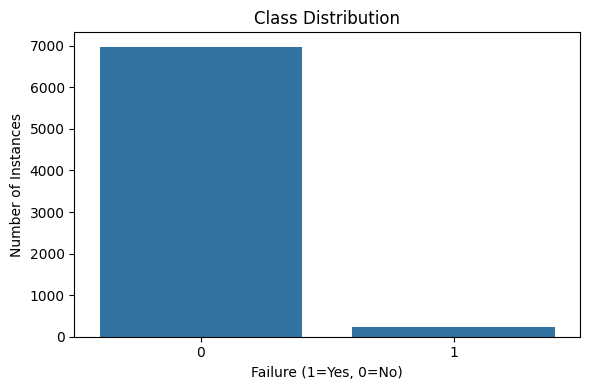

In [24]:
# Plot the distribution
plt.figure(figsize=(6,4))
sns.barplot(x=failure_counts.index, y=failure_counts.values)
plt.title('Class Distribution')
plt.xlabel('Failure (1=Yes, 0=No)')
plt.ylabel('Number of Instances')
plt.tight_layout()

<div class="alert alert-info">
If the classes are imbalanced (e.g., significantly more non-failures than failures), consider techniques like resampling during model training.
</div>

# 4) Model Building

## 4a) Defining Features and Target Variable

In [25]:
# Define feature set and target variable
X = df.drop(['failure'], axis=1)
y = df['failure']

print(f'Feature set shape: {X.shape}')
print(f'Target variable shape: {y.shape}')

Feature set shape: (7200, 12)
Target variable shape: (7200,)


## 4b) Handling Class Imbalance (If Applicable)

Assuming there's class imbalance, we can use techniques like SMOTE or `class_weight` parameter in models.

In [26]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y), y=y
    )
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5162770686935322, 1: 15.859030837004406}

## 4c) Splitting the Data

In [27]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 5760
Testing samples: 1440


## 4d) Building the Pipeline

Using a pipeline ensures that preprocessing steps are applied consistently during training and testing.

In [28]:
# Define categorical and numerical features
categorical_features = ['equipment_id', 'maintenance']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing for numerical data
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
    ])

# Preprocessing for categorical data
categorical_pipeline = Pipeline([
    ('encoder', 'passthrough')  # Already encoded
    ])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
    ])

# Define the model with class_weights to handle imbalance
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42, class_weight=class_weights_dict
        ))
    ])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temperature', 'vibration_x',
                                                   'vibration_y', 'vibration_z',
                                                   'pressure',
                                                   'rotational_speed', 'hour',
                                                   'day', 'month',
                                                   'dayofweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   'passthrough')]),
                                                  ['equipment_id',
                                                   'maintenance'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 0.5162770686935322,
                                                      1: 15.859030837004406},
                                        random_state=42))])

## 4e) Hyperparameter Tuning (Optional)

In [29]:
# Define parameter grid for GridSearch
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit GridSearch
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temperature',
                                                                          'vibration_x',
                                                                          'vibration_y',
                                                                          'vibration_z',
                                                                          'pressure',
                                                                          'rotational_speed',
                                                                          'hour',
                                                                          'day',
                                                                          'month',
                                                                          'dayofweek']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          'passthrough')]),
                                                                         ['equipment_id',
                                                                          'maintenance'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight={0: 0.5162770686935322,
                                                                             1: 15.859030837004406},
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [30]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_model = grid_search.best_estimator_

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


# 5) Model Evaluation

## 5a) Predictions

In [31]:
# Predict on test data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [32]:
# Check that all labels in y_test appear in y_pred
set(y_test) - set(y_pred)

{1}

<div class="alert alert-warning">
Warning: In this case (because everything is random and there's no true pattern to discover) not all labels in <code>y_test</code> appear in <code>y_pred</code>. This should be noted and addressed by a good applicant.
</div>

## 5b) Classification Report

In [33]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1395
           1       0.00      0.00      0.00        45

    accuracy                           0.97      1440
   macro avg       0.48      0.50      0.49      1440
weighted avg       0.94      0.97      0.95      1440



## 5c) Confusion Matrix

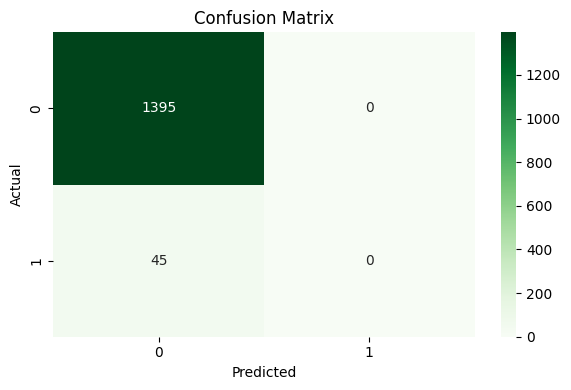

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

## 5d) ROC Curve and AUC

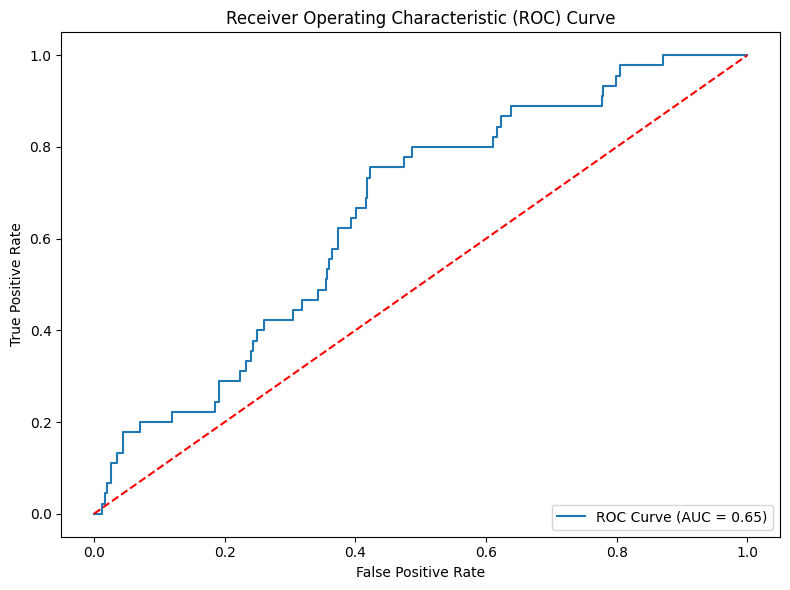

In [35]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'r--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()

## 5f) Feature Importance

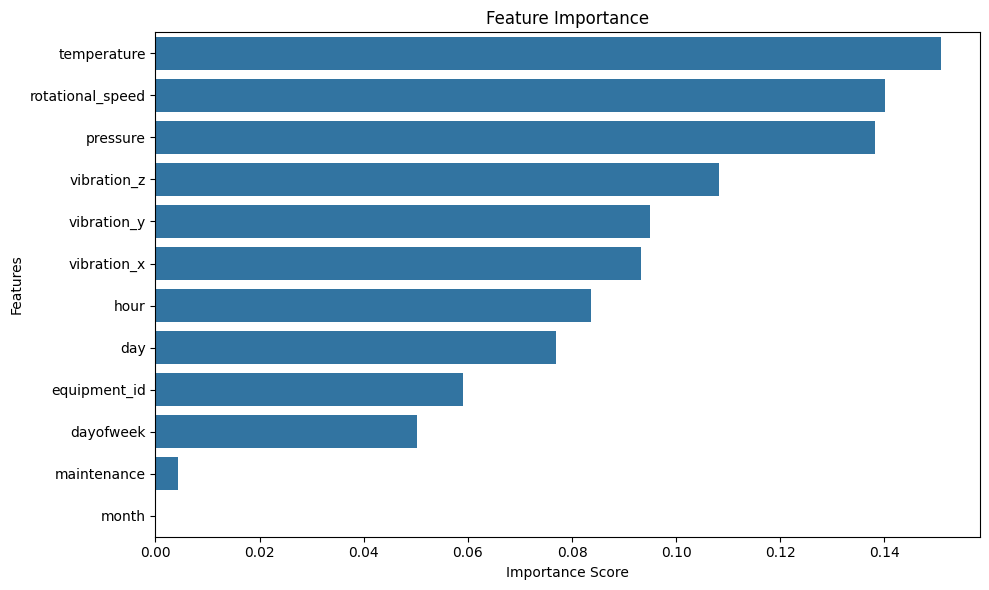

In [36]:
# Extract feature importances from the best model
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = numerical_features + categorical_features
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()

<div class="alert alert-info">
Possible insights:

<ul>
<li> Vibration Sensors (<code>_x</code>, <code>_y</code>, <code>_z</code>): High importance, indicating that elevated vibrations are strong indicators of impending failures.
<li> <code>Temperature</code>: Significant factor; higher temperatures may precede equipment failures.
<li> <code>Rotational Speed</code>: Monitoring RPM can help in predicting anomalies.
</div>

# 7) Recommendations
Based on the model and analysis, here are strategic recommendations to improve maintenance scheduling and reduce equipment failures:

### 1. Enhanced Monitoring of Critical Sensors:
- Focus on vibration sensors (X, Y, Z) and temperature as primary indicators for potential failures.
- We can implement real-time monitoring systems that alert maintenance teams when readings exceed predefined thresholds.

### 2. Scheduled Preventive Maintenance:
- Develop maintenance schedules based on predictive insights to perform maintenance before failures occur.
- This proactive approach minimizes unplanned downtime and extends equipment lifespan.
- They also serve as a backtest for future model evaluation.

### 3. Maintenance Resource Allocation:
- Prioritize maintenance resources towards equipment or shifts where the model predicts a higher likelihood of failure.
- Optimize workforce allocation to ensure timely interventions.

### 4. Anomaly Detection Systems:
- Integrate anomaly detection algorithms that complement the predictive model to identify unusual patterns in equipment behavior early on.

### 5. Continuous Improvement and Model Updating:
- Regularly update the predictive model with new data to maintain its accuracy.
- Incorporate feedback from maintenance teams to refine feature engineering and model parameters.

### 6. Training and Awareness:
- Train operational staff to understand sensor data and predictive alerts. Encourage a culture of preventive maintenance and data-driven decision-making.

### 7. Invest in Robust Equipment:
- Use insights from model feature importance to invest in higher-quality parts or upgrades for components that frequently indicate impending failures.

### 8. Integration with Operational Systems:
- Integrate the predictive maintenance system with existing Enterprise Resource Planning (ERP) and Computerized Maintenance Management Systems (CMMS) for seamless operations.

<div class="alert alert-info">
<ul>
<li> The list provided is rather generic, but should serve as a basic template to guide candidates based on what they find.
<li> This last step may be helpful to gauge the candidate's abilities to serve as PO/PM in his own upcoming projects.
</ul>
</div>